# Introduction to Monte Carlo Methods

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import time

tf.enable_v2_behavior()

## Linear model with homoscedastic error

In [2]:
# forward pass
def forward_pass(xs, num_replicas=1):
    k = xs.shape[0]
    
    beta = tfd.Normal(loc=tf.zeros(k), scale=1.).sample(num_replicas)
    sigma = tfd.Gamma(concentration=0., rate=1.).sample(num_replicas)
    
    mu = tf.linalg.matmul(beta[tf.newaxis, ...], xs)[-1,:]    
    y = tfd.Normal(loc=mu, scale=1.).sample()
    
    return y

In [3]:
k = 4
n = 100
num_replicas = 3

x = tfd.Uniform(-10, 10).sample((k, n))
x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
y = forward_pass(xs=x, num_replicas=num_replicas)

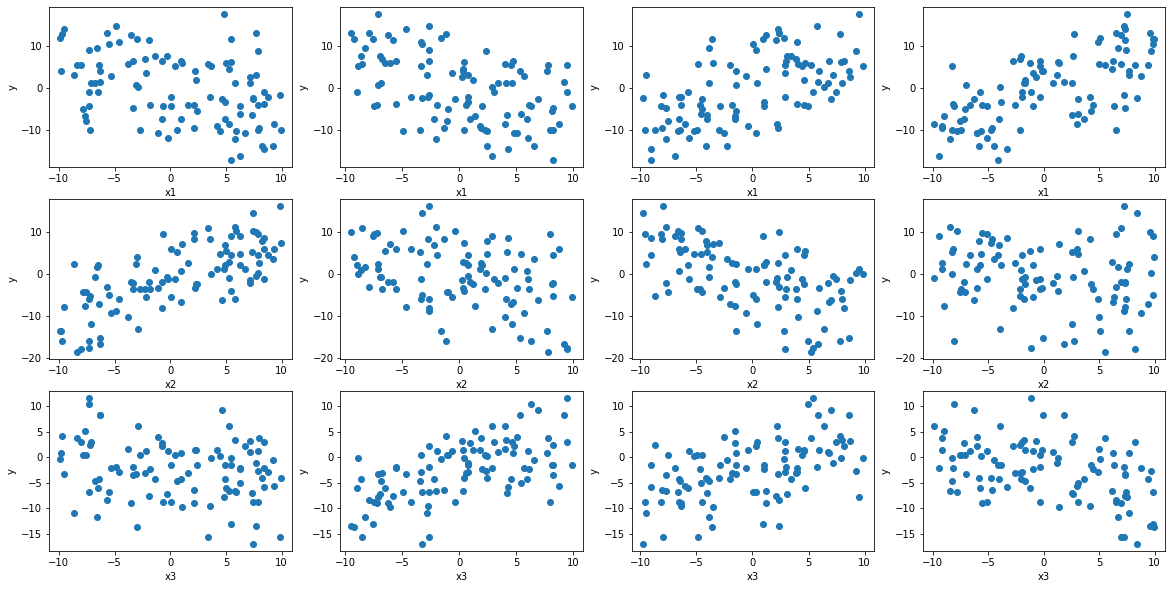

In [4]:
if num_replicas > 1:
    if k>= 2:
        fig, ax = plt.subplots(num_replicas, k,  figsize=(20,10))
        for i in range(num_replicas):
            for j in range(0, k):
                ax[i, j].plot(x[j+1, :], y[i, :], "o")
                ax[i, j].set_xlabel(f"x{i+1}")
                ax[i, j].set_ylabel("y")
                
    else:
        fig, ax = plt.subplots(1, num_replicas, figsize=(20,8))
        for i in range(num_replicas):
            for j in range(0, k):
                ax[i].plot(x[j, :], y[i, :], "o")
                ax[i].set_xlabel(f"x{i+1}")
                ax[i].set_ylabel("y")
else:
    if k>= 2:
        fig, ax = plt.subplots(1, k-1,  figsize=(20,5))
        for j in range(0, k):
            ax[j].plot(x[j+1, :], y[i, :], "o")
            ax[j].set_xlabel(f"x{j+1}")
            ax[j].set_ylabel("y")
                
    else:
        fig, ax = plt.subplots(1,1, figsize=(20,5))
        for j in range(0, k):
            ax.plot(x[j, :], y[0, :], "o")
            ax.set_xlabel(f"x{i+1}")
            ax.set_ylabel("y")

## Analytic Solution

I assume that the reader has a basic knwoledge of Bayesian techniques. Good introductory books are Koop et al. and McElreath.
Given we observe values 

The goal of this first tutorial is to introduce the MCMC methods of Tensorflow Probability. Therefore I start with a simple lienar model with unknown weights and noise parameters. The model is given by: 
\begin{equation}
    y_{i} = \beta_{0} + \beta_{y}x_{i1} + \beta_{y}x_{i2} + \ldots + \beta_{y}x_{ik} + \epsilon_{i}
\end{equation}

Under the assumotion that the error is homoscedastic and normally distributed around 0 ($\epsilon_{i} \sim \mathcal{N}(0, \sigma^2)$). The model is specified as follows:

\begin{align}
    y_{i} \vert \beta \sim \mathcal{N}\left(\beta_{0} + \beta_{y}x_{i1} + \beta_{y}x_{i2} + \ldots + \beta_{y}x_{ik}, \sigma^2 \right)
\end{align}

or in matrix notation:

\begin{align}
    y \vert \beta \sim \mathcal{N}\left(X\beta, \Sigma \right), \quad \Sigma = \sigma^2*I_{N}
\end{align}




While it is unrealistic that we do know know $\beta$, but $\sigma$, I will make this assumption for pedagocial reasons.
Also for pedagocial reasons I will start with a Normal prior so that we can compare anlytica and simulation results.

prior for beta
$\beta \sim \mathcal{N}\left(\beta^{0}, K^-1 \right)$ where $K=a*I_{N}$ the precision Matrix

Using Bayes Theorem this can be written as:
\begin{align}
    p(\beta \vert y) &= \frac{p(y \vert \beta) * p(\beta)}{\int p(y \vert \beta) * p(\beta) d \beta} \\
    &\propto p(y \vert \beta) * p(\beta) \\
    &\propto \mathcal{N}(X\beta, \Sigma) * \mathcal{N}(\beta_{0}, K^{-1}) \\
    &\propto \mathcal{N}(X\beta, \Sigma) * \mathcal{N}(\beta_{0}, K^{-1}) \\
\end{align}

Therefore our posterior is:

$\beta \vert y \sim \mathcal{N}\left( , \right)$


### MCMC

In [5]:
x_obs = np.array(x)
y_obs = np.array(y[0, ]).ravel()

In [6]:
print(x_obs.shape)
print(y_obs.shape)

(5, 100)
(100,)


In [7]:
# backward pass
def joint_log_prob(beta, xs, ys):
    k = xs.shape[0]
    
    # prior
    beta_rv = tfd.MultivariateNormalDiag(loc=tf.zeros(k), scale_diag=tf.ones(k))
    mu = tf.linalg.matmul(beta[tf.newaxis, ...], xs)[-1,:]
    y_rv = tfd.Normal(loc=mu, scale=1.)

    return beta_rv.log_prob(beta) +  tf.reduce_sum(y_rv.log_prob(ys), axis=-1)


def unnormalized_posterior(beta):
    return joint_log_prob(beta, x_obs, y_obs)

### Gibbs Sampler

### Metropolis Hastings

Goal: Sample from target distribution $p(x)$ by drawing from proposal distribution $q(x)$.


Metropolis Hastings
Pseudo Code

1. Draw from $\theta_cand$ = $q(x)$

2. Calculate $\alpha = min()$

2.1 If $\alpha = 1$ accept

else if $\alpha < 1$ accept with probabilty $\alpha$






In [68]:
from tensorflow_probability.python.mcmc.internal import util as mcmc_util

In [78]:
class mh_kernel():  #, target_log_prob_fn):
    def __init__(self,
               new_state_fn=None,
               seed=None,
               name=None):
    if new_state_fn is None:
        new_state_fn = random_walk_normal_fn()

    self._target_log_prob_fn = target_log_prob_fn
    self._seed_stream = SeedStream(seed, salt='RandomWalkMetropolis')
    self._name = name
    self._parameters = dict(
        target_log_prob_fn=target_log_prob_fn,
        new_state_fn=new_state_fn,
        seed=seed,
        name=name)

    @property
    def target_log_prob_fn(self):
        return self._parameters['target_log_prob_fn']

    @property
    def new_state_fn(self):
        return self._parameters['new_state_fn']

    @property
    def seed(self):
        return self._parameters['seed']

    @property
    def name(self):
        return self._parameters['name']

    @property
    def parameters(self):
    """Return `dict` of ``__init__`` arguments and their values."""
        return self._parameters
    
    @property
    def is_calibrated(self):
        return False

    @mcmc_util.set_doc(RandomWalkMetropolis.one_step.__doc__)
    def one_step(self, current_state, previous_kernel_results):
        with tf.name_scope(mcmc_util.make_name(self.name, 'rwm', 'one_step')):
            with tf.name_scope('initialize'):
                if mcmc_util.is_list_like(current_state):
                    current_state_parts = list(current_state)
                else:
                    current_state_parts = [current_state]
                current_state_parts = [
                    tf.convert_to_tensor(s, name='current_state')
                    for s in current_state_parts
                    ]

            next_state_parts = self.new_state_fn(current_state_parts,  # pylint: disable=not-callable
                                           self._seed_stream())
          # Compute `target_log_prob` so its available to MetropolisHastings.
        next_target_log_prob = self.target_log_prob_fn(*next_state_parts)  # pylint: disable=not-callable

        def maybe_flatten(x):
            return x if mcmc_util.is_list_like(current_state) else x[0]

    return [
          maybe_flatten(next_state_parts),
          UncalibratedRandomWalkResults(
              log_acceptance_correction=tf.zeros_like(next_target_log_prob),
              target_log_prob=next_target_log_prob,
          ),
      ]

    def bootstrap_results(self, init_state):
        with tf.name_scope(mcmc_util.make_name(
            self.name, 'rwm', 'bootstrap_results')):
        if not mcmc_util.is_list_like(init_state):
            init_state = [init_state]
        init_state = [tf.convert_to_tensor(x) for x in init_state]
        init_target_log_prob = self.target_log_prob_fn(*init_state)  # pylint:disable=not-callable
    return UncalibratedRandomWalkResults(
        log_acceptance_correction=tf.zeros_like(init_target_log_prob),
        target_log_prob=init_target_log_prob
    )

In [79]:
inner_kernel=mh_kernel()


In [80]:
@tf.function
def run_chain(initial_state, num_results=2000, num_burnin=1000, num_chains=4):
    tfp.mcmc.sample_chain(
        kernel=inner_kernel,
        num_results=num_results, 
        current_state=initial_state,
        num_burnin_steps=num_burnin,
        trace_fn=lambda cs, kr: kr,
        parallel_iterations=num_chains
    )
    return None

In [81]:
num_results = 2000
num_burnin = 1000
num_chains = 1
initial_state = tf.zeros(k+1, dtype=float)
#initial_state = tf.convert_to_tensor(np.array([-32, -0.1, 0.45, 0.45, -0.15]), dtype=tf.float32)


run_chain(initial_state=initial_state, num_results=num_results, num_burnin=num_burnin)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

AttributeError: in user code:

    <ipython-input-34-2b2e800cea9d>:3 run_chain  *
        tfp.mcmc.sample_chain(
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:359 sample_chain  **
        parallel_iterations=parallel_iterations)
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:394 trace_scan
        parallel_iterations=parallel_iterations)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:574 new_func
        return func(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:2491 while_loop_v2
        return_same_structure=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:2688 while_loop
        back_prop=back_prop)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:981 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/while_v2.py:174 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:383 _body
        state = loop_fn(state, elems_array.read(i))
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:343 _trace_scan_fn
        parallel_iterations=parallel_iterations)
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:316 smart_for_loop
        parallel_iterations=parallel_iterations
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:574 new_func
        return func(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:2491 while_loop_v2
        return_same_structure=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:2688 while_loop
        back_prop=back_prop)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:981 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/while_v2.py:174 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:314 <lambda>
        body=lambda i, *args: [i + 1] + list(body_fn(*args)),
    <ipython-input-78-74a1a0730c37>:36 one_step
        self._seed_stream())

    AttributeError: 'mh_kernel' object has no attribute '_seed_stream'


In [13]:
kernel=tfp.mcmc.MetropolisHastings(inner_kernel=inner_kernel)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:136: UserWarning: Supplied `TransitionKernel` is already calibrated. Composing `MetropolisHastings` `TransitionKernel` may not be required.
  warnings.warn('Supplied `TransitionKernel` is already calibrated. '


In [21]:
hmc_kernel=tfp.mcmc.UncalibratedHamiltonianMonteCarlo(
        target_log_prob_fn=lambda x: -x - x**2,
        step_size=0.1,
        num_leapfrog_steps=3
)



In [28]:
hmc_kernel.one_step(tf.zeros(3), hmc_kernel.one_step(tf.zeros(3)))

TypeError: one_step() missing 1 required positional argument: 'previous_kernel_results'

In [40]:
@tf.function
def run_chain(initial_state, num_results=2000, num_burnin=1000, num_chains=4):
    tfp.mcmc.sample_chain(
        kernel=inner_kernel,
        num_results=num_results, 
        current_state=initial_state,
        num_burnin_steps=num_burnin,
        trace_fn=lambda cs, kr: kr,
        parallel_iterations=num_chains
    )
    return None

In [41]:
num_results = 2000
num_burnin = 1000
num_chains = 1
initial_state = tf.zeros(k+1)
#initial_state = tf.convert_to_tensor(np.array([-32, -0.1, 0.45, 0.45, -0.15]), dtype=tf.float32)


run_chain(initial_state=initial_state, num_results=num_results, num_burnin=num_burnin)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

ValueError: in user code:

    <ipython-input-34-2b2e800cea9d>:3 run_chain  *
        tfp.mcmc.sample_chain(
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:359 sample_chain  **
        parallel_iterations=parallel_iterations)
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:394 trace_scan
        parallel_iterations=parallel_iterations)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:574 new_func
        return func(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:2491 while_loop_v2
        return_same_structure=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:2688 while_loop
        back_prop=back_prop)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:981 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/while_v2.py:174 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:383 _body
        state = loop_fn(state, elems_array.read(i))
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:343 _trace_scan_fn
        parallel_iterations=parallel_iterations)
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:316 smart_for_loop
        parallel_iterations=parallel_iterations
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:574 new_func
        return func(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:2491 while_loop_v2
        return_same_structure=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:2688 while_loop
        back_prop=back_prop)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:981 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/while_v2.py:180 wrapped_body
        expand_composites=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/nest.py:385 assert_same_structure
        % (str(e), str1, str2))

    ValueError: The two structures don't have the same nested structure.
    
    First structure: type=list str=[<tf.Tensor 'add:0' shape=() dtype=int32>, <tf.Tensor 'Sum:0' shape=() dtype=float32>]
    
    Second structure: type=list str=[0, <tf.Tensor 'Placeholder_1:0' shape=(5,) dtype=float32>, kernel_results(target_log_prob=<tf.Tensor 'Placeholder_2:0' shape=() dtype=float32>)]
    
    More specifically: The two structures don't have the same number of elements. First structure: type=list str=[<tf.Tensor 'add:0' shape=() dtype=int32>, <tf.Tensor 'Sum:0' shape=() dtype=float32>]. Second structure: type=list str=[0, <tf.Tensor 'Placeholder_1:0' shape=(5,) dtype=float32>, kernel_results(target_log_prob=<tf.Tensor 'Placeholder_2:0' shape=() dtype=float32>)]
    Entire first structure:
    [., .]
    Entire second structure:
    [., ., kernel_results(target_log_prob=.)]


In [ ]:
UncalibratedRandomWalkResults = collections.namedtuple(
    'UncalibratedRandomWalkResults',
    [
        'log_acceptance_correction',
        'target_log_prob',        # For "next_state".
    ])


class UncalibratedRandomWalk(kernel_base.TransitionKernel):

    def __init__(self,
               target_log_prob_fn,
               new_state_fn=None,
               seed=None,
               name=None):
    if new_state_fn is None:
        new_state_fn = random_walk_normal_fn()

    self._target_log_prob_fn = target_log_prob_fn
    self._seed_stream = SeedStream(seed, salt='RandomWalkMetropolis')
    self._name = name
    self._parameters = dict(
        target_log_prob_fn=target_log_prob_fn,
        new_state_fn=new_state_fn,
        seed=seed,
        name=name)

    @property
    def target_log_prob_fn(self):
        return self._parameters['target_log_prob_fn']

    @property
    def new_state_fn(self):
        return self._parameters['new_state_fn']

    @property
    def seed(self):
        return self._parameters['seed']

    @property
    def name(self):
        return self._parameters['name']

    @property
    def parameters(self):
    """Return `dict` of ``__init__`` arguments and their values."""
        return self._parameters
    
    @property
    def is_calibrated(self):
        return False

    @mcmc_util.set_doc(RandomWalkMetropolis.one_step.__doc__)
    def one_step(self, current_state, previous_kernel_results):
        with tf.name_scope(mcmc_util.make_name(self.name, 'rwm', 'one_step')):
            with tf.name_scope('initialize'):
                if mcmc_util.is_list_like(current_state):
                    current_state_parts = list(current_state)
                else:
                    current_state_parts = [current_state]
                current_state_parts = [
                    tf.convert_to_tensor(s, name='current_state')
                    for s in current_state_parts
                    ]

            next_state_parts = self.new_state_fn(current_state_parts,  # pylint: disable=not-callable
                                           self._seed_stream())
          # Compute `target_log_prob` so its available to MetropolisHastings.
        next_target_log_prob = self.target_log_prob_fn(*next_state_parts)  # pylint: disable=not-callable

        def maybe_flatten(x):
            return x if mcmc_util.is_list_like(current_state) else x[0]

    return [
          maybe_flatten(next_state_parts),
          UncalibratedRandomWalkResults(
              log_acceptance_correction=tf.zeros_like(next_target_log_prob),
              target_log_prob=next_target_log_prob,
          ),
      ]

    def bootstrap_results(self, init_state):
        with tf.name_scope(mcmc_util.make_name(
            self.name, 'rwm', 'bootstrap_results')):
        if not mcmc_util.is_list_like(init_state):
            init_state = [init_state]
        init_state = [tf.convert_to_tensor(x) for x in init_state]
        init_target_log_prob = self.target_log_prob_fn(*init_state)  # pylint:disable=not-callable
    return UncalibratedRandomWalkResults(
        log_acceptance_correction=tf.zeros_like(init_target_log_prob),
        target_log_prob=init_target_log_prob
    )

In [6]:
kernel=inner_kernel()

In [9]:
kr=kernel.one_step(tf.zeros(3))

In [22]:
kr.target_log_prob

<tf.Tensor: shape=(), dtype=float32, numpy=-2.7568154>

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:136: UserWarning: Supplied `TransitionKernel` is already calibrated. Composing `MetropolisHastings` `TransitionKernel` may not be required.
  warnings.warn('Supplied `TransitionKernel` is already calibrated. '


In [34]:
kernel = tfp.mcmc.MetropolisHastings(
    inner_kernel=mh_kernel
)

@tf.function
def run_chain(initial_state, num_results=2000, num_burnin=1000, num_chains=4):
    chains, kernel_results = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_results=num_results, 
        current_state=initial_state,
        num_burnin_steps=num_burnin,
        trace_fn=lambda cs, kr: kr,
        parallel_iterations=num_chains
    )
    return chains, kernel_results 

In [35]:
num_results = 2000
num_burnin = 1000
num_chains = 1
initial_state = tf.zeros(k+1)
#initial_state = tf.convert_to_tensor(np.array([-32, -0.1, 0.45, 0.45, -0.15]), dtype=tf.float32)


samples, kernel_results  = run_chain(initial_state=initial_state, num_results=num_results, num_burnin=num_burnin)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

TypeError: in user code:

    <ipython-input-29-63c47a779ee9>:3 run_chain  *
        chains, kernel_results = tfp.mcmc.sample_chain(
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:324 sample_chain  **
        previous_kernel_results = kernel.bootstrap_results(current_state)
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:264 bootstrap_results
        pkr = self.inner_kernel.bootstrap_results(init_state)

    TypeError: bootstrap_results() missing 1 required positional argument: 'init_state'


### Random Walk Metropolis Hastings

Default Proposal Distribution

Random Walk Metropolis Hastings

draw $\theta_{cand}$ from $p(\theta_{i}) = N(\theta_{t-i}, \Sigma)$

In [ ]:
# tuning the RandomWalkMetropolis by changing scale of the proposal
rw_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=unnormalized_posterior,
    #new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=1, name=None)
)

In [ ]:
@tf.function
def run_chain(initial_state, num_results=2000, num_burnin=1000, num_chains=4):
    chains, kernel_results = tfp.mcmc.sample_chain(
        kernel=rw_kernel,
        num_results=num_results, 
        current_state=initial_state,
        num_burnin_steps=num_burnin,
        trace_fn=lambda cs, kr: kr,
        parallel_iterations=num_chains
    )
    return chains, kernel_results 

In [ ]:
num_results = 2000
num_burnin = 1000
num_chains = 1
initial_state = tf.zeros(k+1)
#initial_state = tf.convert_to_tensor(np.array([-32, -0.1, 0.45, 0.45, -0.15]), dtype=tf.float32)


samples, kernel_results  = run_chain(initial_state=initial_state, num_results=num_results, num_burnin=num_burnin)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Tuned Proposal Distribution

In [ ]:
# tuning the RandomWalkMetropolis by changing scale of the proposal
rw_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=unnormalized_posterior,
    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.01, name=None)
)

In [ ]:
@tf.function
def run_chain(initial_state, num_results=2000, num_burnin=1000, num_chains=4):
    chains, kernel_results = tfp.mcmc.sample_chain(
        kernel=rw_kernel,
        num_results=num_results, 
        current_state=initial_state,
        num_burnin_steps=num_burnin,
        trace_fn=lambda cs, kr: kr,
        parallel_iterations=num_chains
    )
    return chains, kernel_results 

In [ ]:
num_results = 2000
num_burnin = 1000
num_chains = 1
initial_state = tf.zeros(k+1)
#initial_state = tf.convert_to_tensor(np.array([-32, -0.1, 0.45, 0.45, -0.15]), dtype=tf.float32)


samples, kernel_results  = run_chain(initial_state=initial_state, num_results=num_results, num_burnin=num_burnin)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

MCMC Estiamtes

In [ ]:
beta_mcmc = tf.math.reduce_mean(samples, axis=0)
for i, estimate in enumerate(beta_mcmc):
    print(f"MCMC Estimate for beta_{i}: {estimate}")

OLS Estiamtes

In [ ]:
beta_ols = tf.linalg.solve(tf.linalg.matmul(x_obs, x_obs, adjoint_b=True), tf.linalg.matmul(x_obs, y_obs[..., tf.newaxis]))
for i, estimate in enumerate(beta_ols):
    print(f"OLS Estimate for beta_{i}: {estimate[0]}")

### Hamiltonian Monte Carlo

untuned HMC

In [ ]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

In [ ]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=hmc_kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results
    )

In [ ]:
initial_state = tf.zeros(k + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

hand-tuned HMC

In [ ]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.01),
  num_leapfrog_steps=4)

In [ ]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=hmc_kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results
    )

In [ ]:
initial_state = tf.zeros(k + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

automatic tuned HMC

In [ ]:
def trace_fn(_, pkr):
      return (
          pkr.inner_results.log_accept_ratio,
          pkr.inner_results.accepted_results.target_log_prob,
          pkr.inner_results.accepted_results.step_size)


# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain_hmc(initial_state, num_results=2000, num_burnin_steps=2000):
    
    # Create an HMC TransitionKernel
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        step_size=np.float64(.01),
        num_leapfrog_steps=4)

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = inner_kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps),
        target_accept_prob=0.65,
        adaptation_rate=0.01
    )

    samples, (log_accept_ratio, target_log_prob, step_size) = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        trace_fn=trace_fn
    ) 
    return samples, log_accept_ratio, target_log_prob, step_size

In [ ]:
initial_state = tf.zeros(k + 1)
samples, log_accept_ratio, target_log_prob, step_size = run_chain_hmc(initial_state)
print("Acceptance rate:", tf.reduce_mean(tf.math.minimum(tf.exp(log_accept_ratio), 1)).numpy())

In [ ]:
beta_mcmc = tf.math.reduce_mean(samples, axis=0)
for i, estimate in enumerate(beta_mcmc):
    print(f"MCMC Estimate for beta_{i}: {estimate}")

In [ ]:
beta_ols = tf.linalg.solve(tf.linalg.matmul(x_obs, x_obs, adjoint_b=True), tf.linalg.matmul(x_obs, y_obs[..., tf.newaxis]))
for i, estimate in enumerate(beta_ols):
    print(f"OLS Estimate for beta_{i}: {estimate[0]}")

### No-U-Turn-Sampler (NUTS)

In [ ]:
def trace_fn(_, pkr):
      return (
          pkr.inner_results.log_accept_ratio,
          pkr.inner_results.accepted_results.target_log_prob,
          pkr.inner_results.accepted_results.step_size)


# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain_nuts(initial_state, num_results=2000, num_burnin_steps=2000):
    
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=unnormalized_posterior,
        step_size=np.float64(.01),
        max_tree_depth=10,
        max_energy_diff=1000.0,
        unrolled_leapfrog_steps=1,
        parallel_iterations=10,
        seed=None,
        name=None
    )

    samples, kernel_results = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        #trace_fn=trace_fn
    ) 
    return samples, kernel_results

In [ ]:
initial_state = tf.zeros(k + 1)
samples, kernel_results = run_chain_nuts(initial_state)
print("Acceptance rate:", tf.reduce_mean(tf.math.minimum(tf.exp(log_accept_ratio), 1)).numpy())

In [ ]:
beta_mcmc = tf.math.reduce_mean(samples, axis=0)
for i, estimate in enumerate(beta_mcmc):
    print(f"MCMC Estimate for beta_{i}: {estimate}")

In [ ]:
beta_ols = tf.linalg.solve(tf.linalg.matmul(x_obs, x_obs, adjoint_b=True), tf.linalg.matmul(x_obs, y_obs[..., tf.newaxis]))
for i, estimate in enumerate(beta_ols):
    print(f"OLS Estimate for beta_{i}: {estimate[0]}")

In [ ]:
def trace_fn(_, pkr):
      return (
          pkr.inner_results.log_accept_ratio,
          pkr.inner_results.accepted_results.target_log_prob,
          pkr.inner_results.accepted_results.step_size)

# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain_nuts_adaptive(initial_state, num_results=2000, num_burnin_steps=2000, adaptation_steps=100):
    
    inner_kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=unnormalized_posterior,
        step_size=np.float64(.01),
        max_tree_depth=10,
        max_energy_diff=1000.0,
        unrolled_leapfrog_steps=1,
        parallel_iterations=10,
        seed=None,
        name=None
    )
    
    adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=inner_kernel,
        num_adaptation_steps=adaptation_steps,
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
        step_size_getter_fn=lambda pkr: pkr.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
    )

    samples, kernel_results = tfp.mcmc.sample_chain(
        kernel=adaptive_kernel,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        #trace_fn=trace_fn
    ) 
    return samples, kernel_results

In [ ]:
initial_state = tf.zeros(k + 1)
samples, kernel_results = run_chain_nuts_adaptive(initial_state)
print("Acceptance rate:", tf.reduce_mean(tf.math.minimum(tf.exp(log_accept_ratio), 1)).numpy())

In [ ]:
beta_mcmc = tf.math.reduce_mean(samples, axis=0)
for i, estimate in enumerate(beta_mcmc):
    print(f"MCMC Estimate for beta_{i}: {estimate}")

In [ ]:
beta_ols = tf.linalg.solve(tf.linalg.matmul(x_obs, x_obs, adjoint_b=True), tf.linalg.matmul(x_obs, y_obs[..., tf.newaxis]))
for i, estimate in enumerate(beta_ols):
    print(f"OLS Estimate for beta_{i}: {estimate[0]}")

## Linear model with unknown homoscedastic error

In [ ]:
sigma_rv = tfd.Gamma(concentration=1e-3, rate=1e-3)
print(sigma_rv.mean())
print(sigma_rv.variance())

In [ ]:
# backward pass
def joint_log_prob(beta, sigma, xs, ys):
    k = xs.shape[0]
    
    # prior
    beta_rv = tfd.MultivariateNormalDiag(loc=tf.zeros(k), scale_diag=tf.ones(k))
    sigma_rv = tfd.Gamma(concentration=5e-4, rate=1e-3)
    
    mu = tf.linalg.matmul(beta[tf.newaxis, ...], xs)[-1,:]
    y_rv = tfd.Normal(loc=mu, scale=sigma[..., tf.newaxis])

    return beta_rv.log_prob(beta) + sigma_rv.log_prob(sigma) + tf.reduce_sum(y_rv.log_prob(ys), axis=-1)


def unnormalized_posterior(beta, sigma):
    return joint_log_prob(beta, sigma,  x_obs, y_obs)

### Gibbs Sampler

In [ ]:
num_burnin

### Metropolis Hastings

### Random Walk Metropolis Hastings

### Hamiltonian Monte Carlo 

In [ ]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
    # Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior,
    step_size=np.float64(.001),
    num_leapfrog_steps=2
)

transformed_kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=hmc_kernel,
    bijector=[tfp.bijectors.Identity(),    # w
              tfp.bijectors.Invert(tfp.bijectors.Softplus())])   # sigma


@tf.function
def run_chain_hmc(initial_state, num_results=1000, num_burnin_steps=1000):
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        transformed_kernel,
        num_adaptation_steps=int(.8 * num_burnin_steps),
        target_accept_prob=np.float64(.65)
    )
    
    samples, kernel_results = tfp.mcmc.sample_chain(
        kernel=adaptive_kernel, #transformed_kernel,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        trace_fn=lambda current_state, kernel_results: kernel_results # lambda cs, kr: kr
    )
    
    return samples, kernel_results

#num_chains = 1
#beta_init = tf.zeros((num_chains, k + 1))
#sigma_init = tf.ones((num_chains, 1))
#initial_state = [beta_init, sigma_init]


num_chains = 1
initial_state=[np.ones((num_chains, k + 1), dtype=np.float32), .54 * np.ones((num_chains, ), dtype=np.float32)]

samples, kernel_results = run_chain_hmc(initial_state) #
print("Acceptance rate:", kernel_results.inner_results.inner_results.is_accepted.numpy().mean())

In [ ]:
beta_mcmc = tf.math.reduce_mean(samples[0], axis=0)
for j in range(beta_mcmc.shape[1]):
    for i, estimate in enumerate(beta_mcmc[:, j]):
        print(f"MCMC Estimate for beta_{j} from chain {i+1}: {estimate}")

In [ ]:
sigma_mcmc = tf.math.reduce_mean(samples[1], axis=0)
for j, estimate in enumerate(sigma_mcmc):
        print(f"MCMC Estimate for sigma from chain {j+1}: {estimate}")

### No U-Turn Sampler

## Linear model with unknown hetroscedastic error